In [727]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [728]:
df_train = pd.read_csv("train.csv")

In [729]:
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


To see if any NA value

In [730]:
df_train.info()
print("**************************\ndf_train has ", df_train.isna().sum().sum(), "missing values.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
**************************
df_train has  149 missing values.


In [731]:
# drop the ID columns
df_train.drop(["Loan_ID"], axis = 1, inplace=True)

### Draw the box plot of the target variable

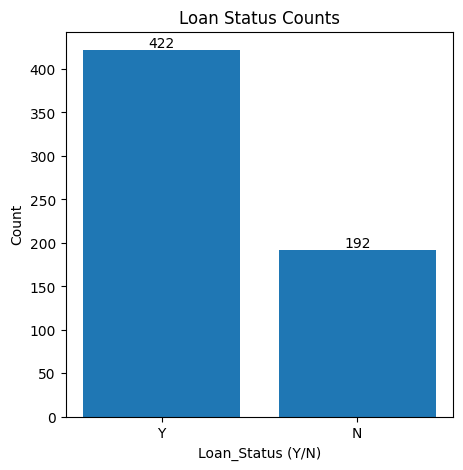

In [732]:
# Count the occurrences of each loan status
loan_status_counts = df_train['Loan_Status'].value_counts()

plt.figure(figsize=(5, 5))
bars = plt.bar(loan_status_counts.index, loan_status_counts.values)
plt.xlabel('Loan_Status (Y/N)')
plt.ylabel('Count')
plt.title('Loan Status Counts')

# Adding the count above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center')

plt.show()

### Fill nan in the numeric columns

In [733]:
# continuous columns list
con_columns = df_train.select_dtypes(exclude = ['object']).columns.to_list()
# Calculate the median for each column
mean = df_train[con_columns].mean()
# Apply the fillna method to each column
df_train[con_columns] = df_train[con_columns].apply(lambda x: x.fillna(x.median()))

### One-Hot-Encoding

In [734]:
# Select the object column, and turn them into category
object_columns = df_train.select_dtypes(include = ['object']).columns.to_list()
object_columns.remove("Loan_Status") # Loan_Status don't need to encoding by dummy
# Perform one-hot encoding
df_train = pd.get_dummies(df_train, columns = object_columns)

# encode the target column
dict1 = {"Y":1, "N":0}
df_train["Loan_Status"] = df_train["Loan_Status"].map(dict1)

# copy for model 2
df_train2 = df_train.copy()

df_y = df_train["Loan_Status"]
df_train.drop(['Loan_Status'], axis = 1, inplace=True)

In [735]:
# reorder the columns
cols = df_train2.columns.to_list()
cols.remove("Loan_Status")

df_train2 = df_train2[cols + ["Loan_Status"]]
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ApplicantIncome          614 non-null    int64  
 1   CoapplicantIncome        614 non-null    float64
 2   LoanAmount               614 non-null    float64
 3   Loan_Amount_Term         614 non-null    float64
 4   Credit_History           614 non-null    float64
 5   Gender_Female            614 non-null    uint8  
 6   Gender_Male              614 non-null    uint8  
 7   Married_No               614 non-null    uint8  
 8   Married_Yes              614 non-null    uint8  
 9   Dependents_0             614 non-null    uint8  
 10  Dependents_1             614 non-null    uint8  
 11  Dependents_2             614 non-null    uint8  
 12  Dependents_3+            614 non-null    uint8  
 13  Education_Graduate       614 non-null    uint8  
 14  Education_Not Graduate   6

### Model 1 LogisticRegression

In [736]:
con_columns

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

Testing Accuracy: 0.8054054054054054
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.47      0.63        66
           1       0.77      0.99      0.87       119

    accuracy                           0.81       185
   macro avg       0.87      0.73      0.75       185
weighted avg       0.84      0.81      0.78       185



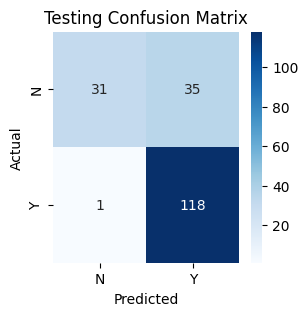

In [737]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_train, df_y, test_size=0.3, random_state=15)

# Calculate mean and standard deviation for normalization
trans_m = np.mean(X_train[con_columns], axis=0)
trans_std = np.std(X_train[con_columns], axis=0)

# Normalize the numeric columns in the training set
X_train[con_columns] = (X_train[con_columns] - trans_m) / trans_std

# Normalize the numeric columns in the test set using the same mean and standard deviation
X_test[con_columns] = (X_test[con_columns] - trans_m) / trans_std


# Create a logistic regression model
model1 = LogisticRegression()

# Train the model
model1.fit(X_train, y_train)

# Make predictions
y_pred = model1.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Testing Accuracy:", accuracy)
print("Classification Report:\n", report)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting using matplotlib and seaborn
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'Y'], yticklabels=['N', 'Y'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Testing Confusion Matrix')
plt.show()

Training Accuracy: 0.8158508158508159
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.42      0.57       126
           1       0.80      0.98      0.88       303

    accuracy                           0.82       429
   macro avg       0.85      0.70      0.73       429
weighted avg       0.83      0.82      0.79       429



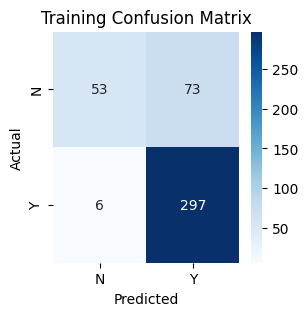

In [738]:
# Make predictions
y_train_pred = model1.predict(X_train)

# Evaluate the model
accuracy = accuracy_score(y_train, y_train_pred)
report = classification_report(y_train, y_train_pred)

print("Training Accuracy:", accuracy)
print("Classification Report:\n", report)

# Compute the confusion matrix
cm = confusion_matrix(y_train, y_train_pred)

# Plotting using matplotlib and seaborn
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'Y'], yticklabels=['N', 'Y'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Training Confusion Matrix')
plt.show()

### The Coefficient of logistic regression

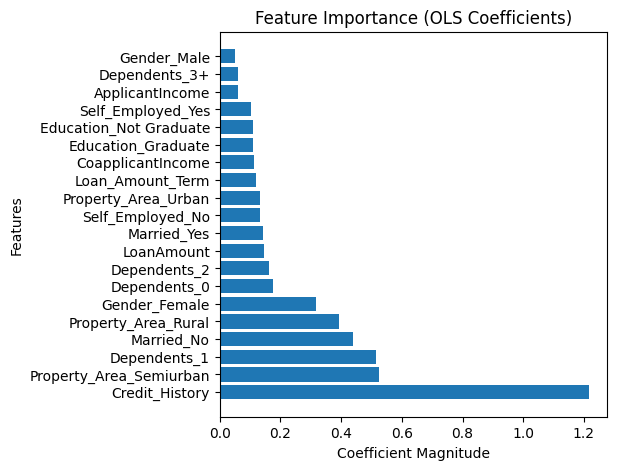

In [739]:
# Get the coefficients
coefficients = model1.coef_.flatten()

# Map coefficients to column names
coef_dict = {'Feature': X_train.columns, 'Coefficient': coefficients}

# Create a DataFrame
coef_df = pd.DataFrame(coef_dict)

# Sort the DataFrame by the absolute value of coefficients
# to understand the importance (both positive and negative impact)
coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

plt.figure(figsize=(5, 5))
bars = plt.barh(coef_df["Feature"], coef_df["Coefficient"].abs())  # Using barh for horizontal bars
plt.ylabel('Features')  # Label for y-axis
plt.xlabel('Coefficient Magnitude')  # Label for x-axis
plt.title('Feature Importance (OLS Coefficients)')
plt.show()

### Model 2 ols - select all features

In [740]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ApplicantIncome          614 non-null    int64  
 1   CoapplicantIncome        614 non-null    float64
 2   LoanAmount               614 non-null    float64
 3   Loan_Amount_Term         614 non-null    float64
 4   Credit_History           614 non-null    float64
 5   Gender_Female            614 non-null    uint8  
 6   Gender_Male              614 non-null    uint8  
 7   Married_No               614 non-null    uint8  
 8   Married_Yes              614 non-null    uint8  
 9   Dependents_0             614 non-null    uint8  
 10  Dependents_1             614 non-null    uint8  
 11  Dependents_2             614 non-null    uint8  
 12  Dependents_3+            614 non-null    uint8  
 13  Education_Graduate       614 non-null    uint8  
 14  Education_Not Graduate   6

In [741]:
# split the dataset into a training set (80%) and testing set (20%) with random seed = 1.
train, test = train_test_split(df_train2, test_size=0.3, random_state=15)

# Calculate mean and standard deviation for normalization
trans_m = np.mean(train[con_columns], axis=0)
trans_std = np.std(train[con_columns], axis=0)

# Normalize the numeric columns in the training set
train[con_columns] = (train[con_columns] - trans_m) / trans_std

# Normalize the numeric columns in the test set using the same mean and standard deviation
test[con_columns] = (test[con_columns] - trans_m) / trans_std

# all the variables, except the DENGUE
cols = df_train.columns.to_list()

# Model 2 : select all
# Wrap column names in Q("") if they contain spaces or special characters
safe_cols = [f'Q("{col}")' if ' ' in col or not col.isalnum() else col for col in cols]

# Fit on training set
formula_all = 'Loan_Status ~ ' + ' + '.join(safe_cols) # all
model2 = ols(formula_all, data=train).fit() 
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:            Loan_Status   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     10.27
Date:                Mon, 25 Dec 2023   Prob (F-statistic):           6.31e-24
Time:                        20:56:12   Log-Likelihood:                -191.49
No. Observations:                 429   AIC:                             421.0
Df Residuals:                     410   BIC:                             498.1
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [742]:
# Predict the training and testing set
# all numeric features
y_pred = model2.predict(test) # predict testing
y_train_pred = model2.predict(train) # predict training

#### Use ROC curve to find the optimal_threshold

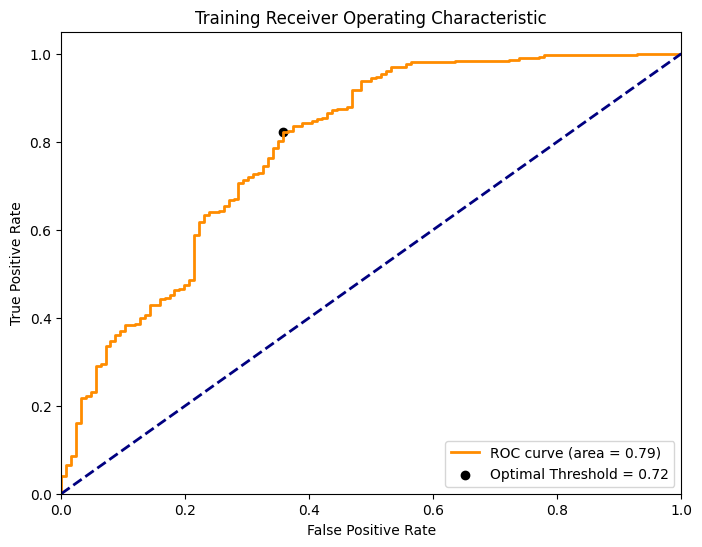

Optimal Threshold: 0.7239572958413655


In [743]:
# Compute TPR, FPR, and thresholds
fpr, tpr, thresholds = roc_curve(train["Loan_Status"], y_train_pred)

# Calculate the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Optimal threshold
print(f'Optimal Threshold: {optimal_threshold}')


Training Accuracy: 0.7668997668997669
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.64      0.62       126
           1       0.85      0.82      0.83       303

    accuracy                           0.77       429
   macro avg       0.72      0.73      0.73       429
weighted avg       0.77      0.77      0.77       429



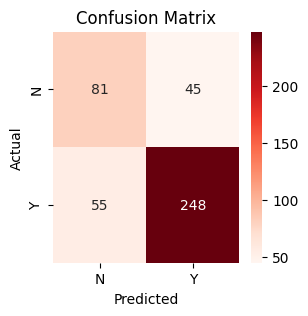

In [744]:
# Convert probabilities to binary predictions based on the optimal threshold
y_train_pred = (y_train_pred > optimal_threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(train['Loan_Status'], y_train_pred)
report = classification_report(train['Loan_Status'], y_train_pred)

print("Training Accuracy:", accuracy)
print("Classification Report:\n", report)

# Compute the confusion matrix
cm = confusion_matrix(y_train, y_train_pred)

# Plotting using matplotlib and seaborn
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['N', 'Y'], yticklabels=['N', 'Y'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

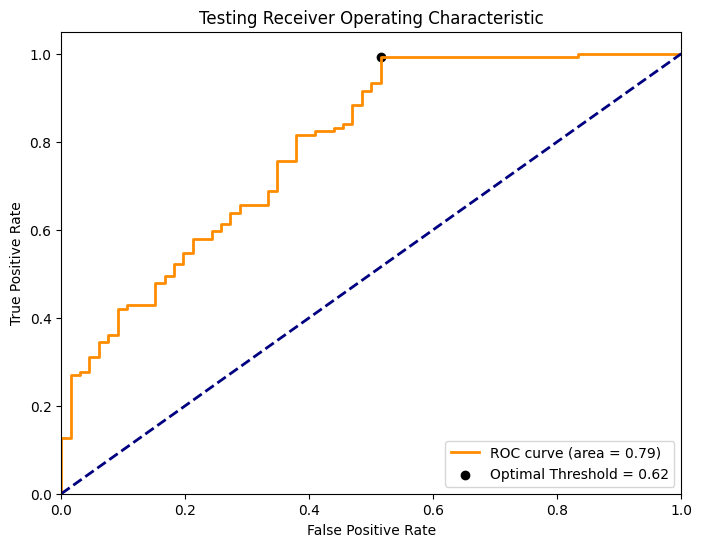

Optimal Threshold: 0.622919252965366


In [745]:
# Compute TPR, FPR, and thresholds
fpr, tpr, thresholds = roc_curve(test["Loan_Status"], y_pred)

# Calculate the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Testing Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Optimal threshold
print(f'Optimal Threshold: {optimal_threshold}')


Testing Accuracy: 0.8054054054054054
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.48      0.64        66
           1       0.77      0.98      0.87       119

    accuracy                           0.81       185
   macro avg       0.86      0.73      0.75       185
weighted avg       0.83      0.81      0.79       185



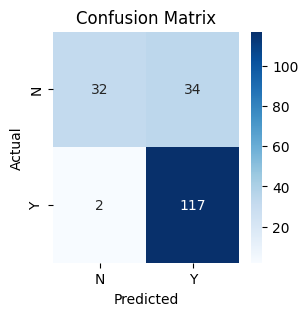

In [746]:
# Convert probabilities to binary predictions based on the optimal threshold
y_pred = (y_pred > optimal_threshold).astype(int)

# Evaluate the model
accuracy = accuracy_score(test['Loan_Status'], y_pred)
report = classification_report(test['Loan_Status'], y_pred)

print("Testing Accuracy:", accuracy)
print("Classification Report:\n", report)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting using matplotlib and seaborn
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'Y'], yticklabels=['N', 'Y'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

OLS 的 feature importance，藉由排序特徵的coefficients

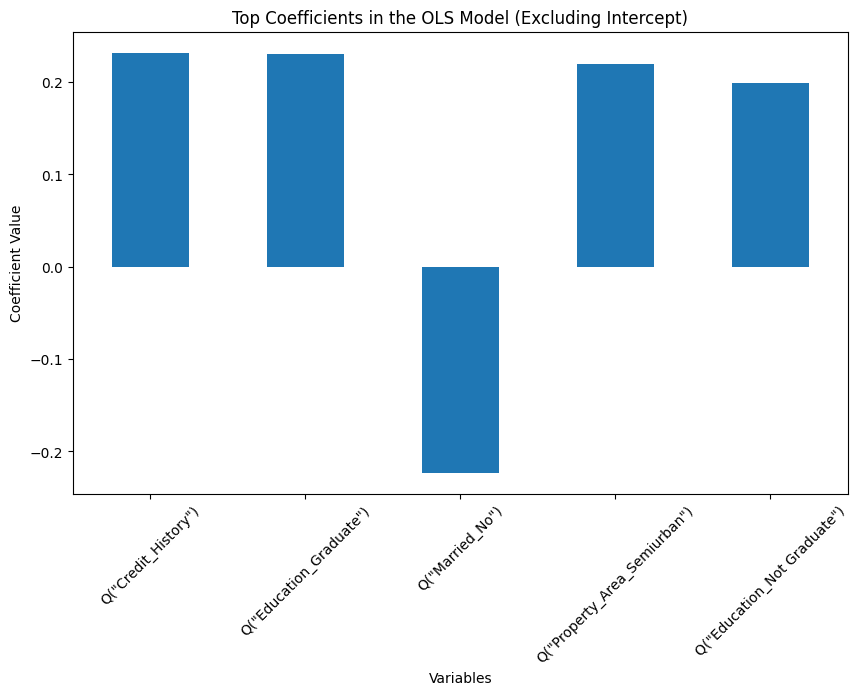

In [747]:
# Extracting coefficients
coefficients = model2.params

# Create a DataFrame from the coefficients
coef_df = pd.DataFrame(coefficients, columns=['Coefficient'])

# Sort the DataFrame by the absolute value of the coefficients
sorted_coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

# Select the top 5 coefficients
top_5_coefs = sorted_coef_df.head(6)
# Check if 'Intercept' is in the index and drop it if present
if 'Intercept' in top_5_coefs.index:
    top_5_coefs = top_5_coefs.drop('Intercept', axis=0)

# Now 'top_5_coefs' doesn't contain the 'Intercept'
# plot the bar plot for the remaining coefficients

plt.figure(figsize=(10, 6))
top_5_coefs['Coefficient'].plot(kind='bar')
plt.title('Top Coefficients in the OLS Model (Excluding Intercept)')
plt.ylabel('Coefficient Value')
plt.xlabel('Variables')
plt.xticks(rotation=45)
plt.show()

In [748]:
print(sorted_coef_df)

                              Coefficient
Intercept                        0.428317
Q("Credit_History")              0.231815
Q("Education_Graduate")          0.229766
Q("Married_No")                 -0.223071
Q("Property_Area_Semiurban")     0.219145
Q("Education_Not Graduate")      0.198551
Q("Married_Yes")                -0.130053
Q("Property_Area_Urban")         0.128027
Q("Gender_Female")               0.104662
Q("Property_Area_Rural")         0.081145
Q("Dependents_1")               -0.069434
Q("Gender_Male")                 0.066789
Q("Dependents_0")                0.043508
Q("Dependents_2")                0.040792
Q("Self_Employed_No")           -0.030152
Q("Dependents_3+")               0.023484
LoanAmount                      -0.023162
CoapplicantIncome               -0.021008
Q("Self_Employed_Yes")          -0.020281
Q("Loan_Amount_Term")           -0.015058
ApplicantIncome                  0.009316
